# Effects of the Size of the Blind Spot on Dispersion

## Required Imports

In [22]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import matplotlib.pyplot as plt

from fish import Fish

from interaction import Interaction
from environment import Environment
from channel import Channel
from observer import Observer
from dynamics import Dynamics

from utils import generate_distortion, generate_fish, run_simulation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Blind Spot and Dispersion

Change the width of the blind `w_blindspot` spot in the back of BlueBot. `w_blindspot=0` means no blind spot at all. `w_blindspot=50` represents the actual blindspot of the BlueBot. `w_blindspot=(2*1780**2)**(1/2)` means a blind spot wider than the diagonal of the tank environment, i.e. a 180° forward looking field of view only.

Observe the effects of the blindspot on how well the fish disperse, described by their mean neighbor distance and mean speeds after a given `run_time`.

In [28]:
w_blindspot = 50 # [mm]

run_time = 30 # in seconds
num_fish = 25
arena_size = np.array([1780, 1780, 1170])
arena_center = arena_size / 2.0
initial_spread = 260
fish_pos = initial_spread * np.random.rand(num_fish, 3) + arena_center - initial_spread / 2.0
fish_vel = np.zeros((num_fish, 3))
fish_phi = math.pi * np.random.rand(num_fish, 1)
fish_vphi = np.zeros((num_fish, 1))
clock_freqs = 1
verbose = False

distortion = generate_distortion(type='none', magnitude=130, n=math.ceil(arena_size[0]/10)+1, show=False)
environment = Environment(
    arena_size=arena_size,
    node_pos=fish_pos,
    node_vel=fish_vel,
    node_phi=fish_phi,
    node_vphi=fish_vphi,
    distortion=distortion,
    prob_type='binary',
    conn_thres=3000,
    conn_drop=1,
    noise_magnitude=10,
    verbose=verbose
)
interaction = Interaction(environment, verbose=verbose)
channel = Channel(environment)
dynamics = Dynamics(environment, clock_freq=clock_freqs)

fish = generate_fish(
    n=num_fish, 
    channel=channel, 
    interaction=interaction,
    dynamics=dynamics,
    w_blindspot=w_blindspot,
    r_blocking=130,
    target_dist=(2*1780**2)**(1/2),
    lim_neighbors=[2,3],
    neighbor_weights=1.0,
    fish_max_speeds=130,
    clock_freqs=clock_freqs,
    verbose=verbose
)
channel.set_nodes(fish)

observer = Observer(fish=fish, environment=environment, channel=channel)
    
run_simulation(fish=fish, observer=observer, run_time=run_time, dark=False, white_axis=False, no_legend=True)

Please wait patiently 30 seconds. Thanks.
It's time to say bye bye!


## Evaluate the Dispersion

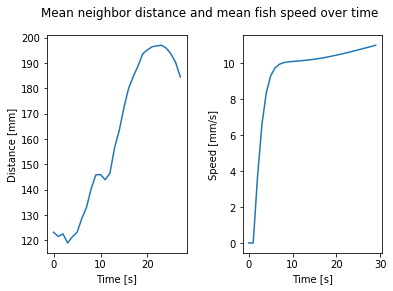

The initial mean neighbor distance is 123.2mm. The initial mean robot speed is 0.0mm/s
The final mean neighbor distance is 184.4mm. The final mean robot speed is 11.0mm/s
The increase in mean neighbor distance is 149.7%


In [24]:
d_mean = observer.d_mean

data = np.zeros((6, run_time, num_fish))
data[0, :, :] = np.transpose(np.array(observer.x))
data[1, :, :] = np.transpose(np.array(observer.y))
data[2, :, :] = np.transpose(np.array(observer.z))
data[3, :, :] = np.transpose(np.array(observer.vx))
data[4, :, :] = np.transpose(np.array(observer.vy))
data[5, :, :] = np.transpose(np.array(observer.vz))

vx_mean = np.sum(data[3, :, :], axis=1)/num_fish
vy_mean = np.sum(data[4, :, :], axis=1)/num_fish
vz_mean = np.sum(data[5, :, :], axis=1)/num_fish

v_mean = np.array([vx_mean, vy_mean, vz_mean])
v_mean_magnitude = np.linalg.norm(v_mean, axis=0)

fig, axs = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.4)

axs[0].plot(d_mean[2:])
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Distance [mm]')
axs[1].plot(v_mean_magnitude)
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Speed [mm/s]')
fig.suptitle('Mean neighbor distance and mean fish speed over time')
plt.show()

print('The initial mean neighbor distance is {0:.1f}mm. The initial mean robot speed is {1:.1f}mm/s'.format(d_mean[2], v_mean_magnitude[0]))
print('The final mean neighbor distance is {0:.1f}mm. The final mean robot speed is {1:.1f}mm/s'.format(d_mean[-1], v_mean_magnitude[-1]))
print('The increase in mean neighbor distance is {0:.1f}%'.format((d_mean[-1]/d_mean[2])*100))

## Prepare Data for Animation

In [25]:
# Get fish data from observer
data = np.zeros((6, run_time, num_fish))
data[0, :, :] = np.transpose(np.array(observer.x))
data[1, :, :] = np.transpose(np.array(observer.y))
data[2, :, :] = np.transpose(np.array(observer.z))
data[3, :, :] = np.transpose(np.array(observer.vx))
data[4, :, :] = np.transpose(np.array(observer.vy))
data[5, :, :] = np.transpose(np.array(observer.vz))

## Save Data

In [92]:
np.save('blindspot', data)

## Animate Simulated Data

Change the speed-up factor of the animation in the variable `speed`. 

In [27]:
# Imports
import ipyvolume as ipv
from ipyvolume.moviemaker import MovieMaker
import ipywidgets as widgets
import ipywebrtc as webrtc
import matplotlib.cm as cm
import time

# Data handling
x, y, z, vx, vy, vz = data
speed = 1 # speed up animation 10 times

# Colors
v = np.sqrt(x**2 + y**2 + z**2)
v -= v.min(); v /= v.max();
colors = np.array([cm.Blues(k) for k in v])
colors[:, -2:, :] = cm.Reds(0.5) # one robot is red
colors[:, -1:, :] = cm.Blues(0.5) # one robot is blue

# Figure
fig = ipv.figure()
ipv.xlim(0, 1780)
ipv.ylim(0, 1780)
ipv.zlim(0, 1170)
ipv.style.use('dark')
quiver = ipv.quiver(x, y, z, vx, vy, vz, size=10, color=colors[:,:,:3])
ipv.animation_control(quiver, interval=1000/speed)
ipv.show()

## Save Animation as html

In [ ]:
ipv.save('blindspot.html')
!open 'blindspot.html'